In [1]:
# imports
import tensorflow as tf
#from tensorflow import keras
import pandas as pd
import numpy as np
import regex as re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import math
from numpy import mean
from numpy import std
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import RepeatedKFold
#from keras.models import Sequential
#from keras.layers import Dense
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [9]:
# load info file
df = pd.read_csv("protein_act_site.tsv", sep="\t")


sequence_list = df['Sequence'].tolist()
active_list = df['Active site'].tolist()
df['length'] = [len(i) for i in sequence_list]
df_short = df[df['length'] < 3000]
#print(df_short)
short_sequence_list = df_short['Sequence'].tolist()
short_active_list = df_short['Active site'].tolist()
length_values = max([len(i) for i in short_sequence_list])
# data prep



acid_code_dict = {"A":"1", "B":"2", "C":"3", "D":"4", "E":"5", "F":"6", "G":"7", "H":"8",
                  "I":"9", "J":"10", "K":"11", "L":"12", "M":"13", "N":"14", "O":"15", "P":"16",
                  "Q":"17", "R":"18", "S":"19", "T":"20", "U":"21", "V":"22", "W":"23", "X":"24",
                  "Y":"25", "Z":"26"}

# prob just turn it into an array as a whole and not a list of arrays but what do i know. 
# one hot encoding of the different amino acids
def one_of_each(seq_list, size):
    #length_values = size
    new_seq_list = []
    for seq in seq_list:
        new_acid_list = np.zeros(size)
        #new_acid_list = []
        for acid in enumerate(seq):
            #print(len(seq))
            #print(acid[1])
            new_acid_list[acid[0]] = (int(acid_code_dict[acid[1]]) / 20) # normalize the data?
        new_seq_list.append(new_acid_list)
    return np.asarray(new_seq_list)


X = one_of_each(short_sequence_list, length_values)
#print(one_of_each(sequence_list, length_values)[0])

def target_regions(target_list, size):
    new_list = []
    for target in target_list:
        empty_array = np.zeros(size)
        #print(target)
        list_of_targets = re.findall('ACT_SITE [0-9]+', target)
        #print(list_of_targets)
        for position in list_of_targets:
            pos_number = position.split(" ")[1]
            #print(pos_number)
            empty_array[int(pos_number)] = 1
        new_list.append(empty_array)
    return np.asarray(new_list)

y = target_regions(short_active_list, length_values)
#print(target_regions(active_list, length_values))
#print(len(max(sequence_list)))
# create vectors of the size of the biggest sequence encode the amino acids 1-idk 20 ish 

# annotate the active regions with a 1 and leave the rest zero

#print(max([len(i) for i in sequence_list]))


# either 1 region per sequence or multiple at the same time. 


print(X.shape)
print(y.shape)

(3825, 2986)
(3825, 2986)


In [61]:
#log_weight = 1 + (pos_weight - 1) * targets
#cross_entropy = tf.nn.weighted_cross_entropy_with_logits(logits=logits, targets=y_, pos_weight=log_weight)


def get_focal_params(y_pred):
    epsilon = tf.constant(1e-9)
    gamma = tf.constant(3.)
    y_pred = y_pred + epsilon
    pinv = 1./y_pred
    pos_weight_f = (pinv - 1)**gamma
    weight_f = y_pred**gamma
    return pos_weight_f, weight_f

def custom_loss(y_true,y_pred):
    y_pred_prob = tf.keras.backend.sigmoid(y_pred)    
    pos_weight_f, weight_f = get_focal_params(y_pred_prob)
    alpha = tf.constant(.35)
    alpha_ = 1 - alpha
    alpha_div = alpha / alpha_
    pos_weight = pos_weight_f * alpha_div
    weight = weight_f * alpha_ + 5

    l2 = weight * tf.nn.weighted_cross_entropy_with_logits\
    (labels=y_true, logits=y_pred, pos_weight=pos_weight)
    return l2

In [85]:
# model

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3000,)),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='sigmoid')
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [86]:
X = X_dna_bind
y = y_dna_bind
train_sequences, test_sequences, train_targets, test_targets = train_test_split(X, y, test_size=0.2)

#for i in (1,2,3,4,5):
model.fit(train_sequences, train_targets, epochs=10)
test_loss, test_acc = model.evaluate(test_sequences,  test_targets, verbose=2)
#    print(i)

#from sklearn.metrics import roc_curve
#y_pred_keras = model.predict(test_sequences).ravel()
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_targets, y_pred_keras)
#from sklearn.metrics import auc
#auc_keras = auc(fpr_keras, tpr_keras)
# 31% after 50 epochs 
#print('\nTest accuracy:', test_acc)

Epoch 1/10
40/40 [==============================] - 18s 435ms/step - loss: 0.1329 - binary_accuracy: 0.9461
Epoch 2/10
40/40 [==============================] - 19s 472ms/step - loss: 0.0030 - binary_accuracy: 0.9999
Epoch 3/10
40/40 [==============================] - 18s 455ms/step - loss: 2.9506e-04 - binary_accuracy: 1.0000
Epoch 4/10
40/40 [==============================] - 18s 439ms/step - loss: 2.5019e-04 - binary_accuracy: 0.9999
Epoch 5/10
40/40 [==============================] - 17s 427ms/step - loss: 1.8021e-04 - binary_accuracy: 1.0000
Epoch 6/10
40/40 [==============================] - 18s 458ms/step - loss: 1.5762e-04 - binary_accuracy: 0.9999
Epoch 7/10
40/40 [==============================] - 19s 472ms/step - loss: 1.7165e-04 - binary_accuracy: 0.9999
Epoch 8/10
40/40 [==============================] - 20s 497ms/step - loss: 1.2167e-04 - binary_accuracy: 1.0000
Epoch 9/10
40/40 [==============================] - 19s 461ms/step - loss: 1.1960e-04 - binary_accuracy: 1.0000


[[6.7092651e-07 2.6574641e-02 1.0735095e-02 ... 1.6576018e-06
  1.0612384e-06 5.7735798e-07]
 [3.7250311e-07 4.0914714e-02 1.9250005e-02 ... 8.5697491e-07
  5.4329496e-07 3.4960237e-07]
 [3.3167624e-09 4.0923655e-03 1.7465651e-03 ... 1.0785942e-08
  5.7988583e-09 2.7415337e-09]
 ...
 [6.8938283e-10 1.2488365e-03 3.1730533e-04 ... 2.9940970e-09
  1.4577988e-09 4.8923460e-10]
 [2.0862744e-08 6.8637431e-03 2.0667911e-03 ... 6.7976572e-08
  3.8056129e-08 1.6212384e-08]
 [1.0022486e-09 1.8241704e-03 6.2182546e-04 ... 3.8488914e-09
  1.9517439e-09 7.5837031e-10]]
[0.         0.00315457 0.38170347 0.38801262 0.40378549 0.41640379
 0.55835962 0.61829653 0.94006309 0.94637224 0.94952681 1.        ]
[0.         0.         0.00657895 0.00657895 0.01644737 0.01644737
 0.02302632 0.02302632 0.02631579 0.02631579 0.04934211 0.04934211
 0.12828947 0.12828947 0.18092105 0.18092105 0.36513158 0.42763158
 0.44736842 0.45394737 0.47039474 0.48355263 0.66447368 0.66447368
 0.93421053 0.94078947 0.99013158

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


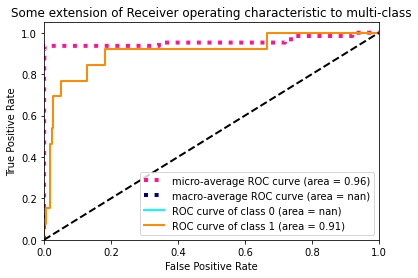

In [87]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
from itertools import cycle
n_classes = 2
lw = 2
y_score = model.predict(test_sequences)
print(y_score)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_targets[:, i], y_score[:, i])
    print(fpr[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_targets.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [6]:
test_loss, test_acc = model.evaluate(test_sequences,  test_targets, verbose=2)

print('\nTest accuracy:', test_acc)

24/24 - 1s - loss: 0.0056 - accuracy: 0.2222

Test accuracy: 0.2222222238779068


In [31]:
# model

model1 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3000,)),
    tf.keras.layers.Dense(3000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='sigmoid')
])


model1.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])


# model

model2 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3000,)),
    tf.keras.layers.Dense(3000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='sigmoid')
])


model2.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])


# model

model3 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3000,)),
    tf.keras.layers.Dense(3000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='sigmoid')
])


model3.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])



# model

model4 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3000,)),
    tf.keras.layers.Dense(3000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='sigmoid')
])


model4.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])



# model

model5 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3000,)),
    tf.keras.layers.Dense(3000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='sigmoid')
])


model5.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])



# model

model6 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3000,)),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='sigmoid')
])


model6.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])





# model

model7 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3000,)),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='sigmoid')
])


model7.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])




# model

model8 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3000,)),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='sigmoid')
])


model8.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])




# model

model9 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3000,)),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='sigmoid')
])


model9.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])




# model

model10 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3000,)),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='sigmoid')
])


model10.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])





# model

model11 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3000,)),
    tf.keras.layers.Dense(1500, activation='relu'),
    tf.keras.layers.Dense(1500, activation='relu'),
    tf.keras.layers.Dense(1500, activation='relu'),
    tf.keras.layers.Dense(3000, activation='sigmoid')
])


model11.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])





# model

model12 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3000,)),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(1500, activation='relu'),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='sigmoid')
])


model12.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])



In [32]:
X = X_dna_bind
y = y_dna_bind
train_sequences, test_sequences, train_targets, test_targets = train_test_split(X, y, test_size=0.2)


modelcount = 1
#for models in (model10, model11):
for models in (model1, model2, model3, model4, model5, model6, model7, model8, model9, model10, model11, model12):
    acc_list = []
    runcount = 1
    for i in (1,2,3,4,5,6,7,8, 9, 10):
        models.fit(train_sequences, train_targets, epochs=10, verbose=0)
        yhat = models.predict(test_sequences)
        yhat = yhat.round()
        acc = accuracy_score(test_targets, yhat)
        acc_list.append(acc)
        #test_loss, test_acc = models.evaluate(test_sequences,  test_targets, verbose=2)
        
        runcount += 1
    print("Model: ", modelcount, ": Acc", acc_list) 
    modelcount += 1


Model:  1 : Acc [0.17034700315457413, 0.19873817034700317, 0.21451104100946372, 0.22712933753943218, 0.2334384858044164, 0.2807570977917981, 0.3217665615141956, 0.3186119873817035, 0.38170347003154576, 0.3627760252365931]
Model:  2 : Acc [0.1892744479495268, 0.2302839116719243, 0.2807570977917981, 0.3470031545741325, 0.3627760252365931, 0.3627760252365931, 0.3753943217665615, 0.38170347003154576, 0.3659305993690852, 0.38485804416403785]
Model:  3 : Acc [0.1861198738170347, 0.2113564668769716, 0.24605678233438485, 0.29652996845425866, 0.3217665615141956, 0.3280757097791798, 0.3659305993690852, 0.38170347003154576, 0.38485804416403785, 0.3911671924290221]
Model:  4 : Acc [0.1608832807570978, 0.19558359621451105, 0.2113564668769716, 0.22712933753943218, 0.2334384858044164, 0.23974763406940064, 0.24921135646687698, 0.277602523659306, 0.2870662460567823, 0.24290220820189273]
Model:  5 : Acc [0.1167192429022082, 0.1640378548895899, 0.19242902208201892, 0.20189274447949526, 0.2176656151419558

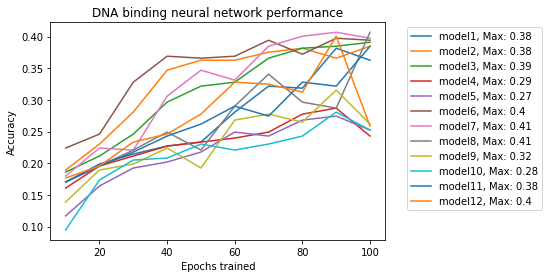

In [84]:
#DNA binding
# plot
#### RERUN
import matplotlib.pyplot as plt
x = [10,20,30,40,50, 60, 70, 80, 90, 100]
model1 = [0.17034700315457413, 0.19873817034700317, 0.21451104100946372, 0.22712933753943218, 0.2334384858044164, 0.2807570977917981, 0.3217665615141956, 0.3186119873817035, 0.38170347003154576, 0.3627760252365931]
model2 = [0.1892744479495268, 0.2302839116719243, 0.2807570977917981, 0.3470031545741325, 0.3627760252365931, 0.3627760252365931, 0.3753943217665615, 0.38170347003154576, 0.3659305993690852, 0.38485804416403785]
model3 = [0.1861198738170347, 0.2113564668769716, 0.24605678233438485, 0.29652996845425866, 0.3217665615141956, 0.3280757097791798, 0.3659305993690852, 0.38170347003154576, 0.38485804416403785, 0.3911671924290221]
model4 = [0.1608832807570978, 0.19558359621451105, 0.2113564668769716, 0.22712933753943218, 0.2334384858044164, 0.23974763406940064, 0.24921135646687698, 0.277602523659306, 0.2870662460567823, 0.24290220820189273]
model5 = [0.1167192429022082, 0.1640378548895899, 0.19242902208201892, 0.20189274447949526, 0.21766561514195584, 0.24921135646687698, 0.24290220820189273, 0.26813880126182965, 0.2744479495268139, 0.25236593059936907]
model6 = [0.22397476340694006, 0.24605678233438485, 0.3280757097791798, 0.36908517350157727, 0.3659305993690852, 0.36908517350157727, 0.3943217665615142, 0.3722397476340694, 0.39747634069400634, 0.3943217665615142]
model7 = [0.17981072555205047, 0.22397476340694006, 0.22082018927444794, 0.305993690851735, 0.3470031545741325, 0.3312302839116719, 0.38485804416403785, 0.40063091482649843, 0.4069400630914827, 0.39747634069400634]
model8 = [0.17034700315457413, 0.19558359621451105, 0.22082018927444794, 0.24921135646687698, 0.22082018927444794, 0.2902208201892745, 0.34069400630914826, 0.29652996845425866, 0.2870662460567823, 0.4069400630914827]
model9 = [0.138801261829653, 0.1892744479495268, 0.19873817034700317, 0.22397476340694006, 0.19242902208201892, 0.26813880126182965, 0.277602523659306, 0.26498422712933756, 0.31545741324921134, 0.2618296529968454]
model10 = [0.0946372239747634, 0.17350157728706625, 0.20504731861198738, 0.2082018927444795, 0.2302839116719243, 0.22082018927444794, 0.2302839116719243, 0.24290220820189273, 0.2807570977917981, 0.25236593059936907]
model11 = [0.17034700315457413, 0.19558359621451105, 0.21766561514195584, 0.24290220820189273, 0.2618296529968454, 0.2902208201892745, 0.2744479495268139, 0.3280757097791798, 0.3217665615141956, 0.38485804416403785]
model12 = [0.17665615141955837, 0.19558359621451105, 0.2334384858044164, 0.24605678233438485, 0.277602523659306, 0.3280757097791798, 0.3249211356466877, 0.31230283911671924, 0.40063091482649843, 0.2586750788643533]

plt.figure(1)
for i, label in zip((model1, model2, model3, model4, model5, model6, model7, model8, model9, model10, model11, model12), ['model1', 'model2', 'model3', 'model4', 'model5', 'model6', 'model7', 'model8', 'model9', 'model10', 'model11', 'model12']):
    test_list = [label, str(round(max(i),2))]
    plt.plot(x, i, label=", Max: ".join(test_list))
plt.title("DNA binding neural network performance")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Epochs trained")
plt.ylabel("Accuracy")
plt.show()

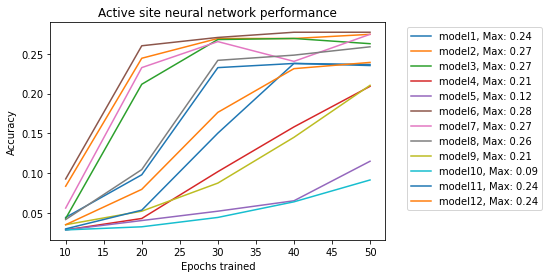

In [85]:
#ACT sites
x = [10,20,30,40,50]
model1 = [0.044444444444444446, 0.09803921568627451, 0.2326797385620915, 0.23790849673202613, 0.23529411764705882]
model2 = [0.08366013071895424, 0.24444444444444444, 0.269281045751634, 0.269281045751634, 0.27450980392156865]
model3 = [0.043137254901960784, 0.21176470588235294, 0.2679738562091503, 0.269281045751634, 0.2627450980392157]
model4 = [0.02875816993464052, 0.043137254901960784, 0.10196078431372549, 0.15816993464052287, 0.20915032679738563]
model5 = [0.02875816993464052, 0.040522875816993466, 0.05228758169934641, 0.06535947712418301, 0.11503267973856209]
model6 = [0.09281045751633987, 0.2601307189542484, 0.27058823529411763, 0.27712418300653596, 0.27712418300653596]
model7 = [0.05620915032679739, 0.2326797385620915, 0.265359477124183, 0.24052287581699347, 0.27450980392156865]
model8 = [0.04183006535947712, 0.10457516339869281, 0.24183006535947713, 0.24836601307189543, 0.25882352941176473]
model9 = [0.03529411764705882, 0.05228758169934641, 0.08758169934640522, 0.1450980392156863, 0.21045751633986928]
model10 = [0.02875816993464052, 0.032679738562091505, 0.044444444444444446, 0.06405228758169934, 0.0915032679738562]
model11 = [0.030065359477124184, 0.05359477124183006, 0.1503267973856209, 0.23790849673202613, 0.23660130718954248]
model12 = [0.03529411764705882, 0.07973856209150326, 0.17647058823529413, 0.23137254901960785, 0.23921568627450981]

plt.figure(1)
for i, label in zip((model1, model2, model3, model4, model5, model6, model7, model8, model9, model10, model11, model12), ['model1', 'model2', 'model3', 'model4', 'model5', 'model6', 'model7', 'model8', 'model9', 'model10', 'model11', 'model12']):
    test_list = [label, str(round(max(i),2))]
    plt.plot(x, i, label=", Max: ".join(test_list))
plt.title("Active site neural network performance")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Epochs trained")
plt.ylabel("Accuracy")
plt.show()

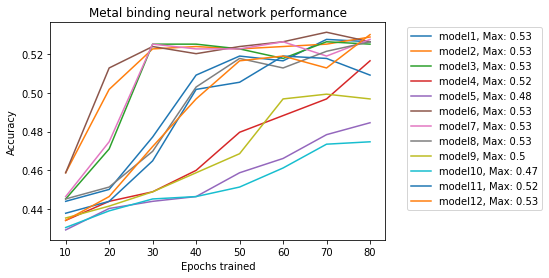

In [86]:
#Metal bidning
x = [10,20,30,40,50, 60, 70, 80]
model1 = [0.4438964241676942, 0.45006165228113443, 0.47718865598027127, 0.5092478421701603, 0.5191122071516646, 0.5166461159062885, 0.5277435265104808, 0.5265104808877928 ]
model2 = [0.45869297163995065, 0.5018495684340321, 0.5228113440197287, 0.5240443896424167, 0.5228113440197287, 0.5240443896424167, 0.5252774352651048, 0.528976572133169 ]
model3 = [0.44512946979038226, 0.47102342786683105, 0.5252774352651048, 0.5252774352651048, 0.5228113440197287, 0.5178791615289766, 0.5265104808877928, 0.5252774352651048 ]
model4 = [0.43403205918618987, 0.4438964241676942, 0.44882860665844637, 0.4599260172626387, 0.4796547472256473, 0.4882860665844636, 0.4969173859432799, 0.5166461159062885 ]
model5 = [0.42909987669543775, 0.4401972872996301, 0.4438964241676942, 0.44636251541307026, 0.45869297163995065, 0.46609124537607893, 0.4784217016029593, 0.4845869297163995 ]
model6 = [0.45869297163995065, 0.5129469790382244, 0.5240443896424167, 0.5203452527743526, 0.5240443896424167, 0.5265104808877928, 0.531442663378545, 0.5265104808877928 ]
model7 = [0.44636251541307026, 0.4747225647348952, 0.5252774352651048, 0.5228113440197287, 0.5228113440197287, 0.5265104808877928, 0.5191122071516646, 0.5277435265104808 ]
model8 = [0.44512946979038226, 0.45129469790382243, 0.46979038224414305, 0.5030826140567201, 0.5178791615289766, 0.5129469790382244, 0.5215782983970407, 0.5265104808877928 ]
model9 = [0.4352651048088779, 0.44143033292231815, 0.44882860665844637, 0.45869297163995065, 0.468557336621455, 0.4969173859432799, 0.499383477188656, 0.4969173859432799 ]
model10 = [0.43033292231812575, 0.43896424167694204, 0.44512946979038226, 0.44636251541307026, 0.45129469790382243, 0.46115906288532676, 0.47348951911220716, 0.4747225647348952, ]
model11 = [0.43773119605425403, 0.4438964241676942, 0.4648581997533909, 0.5018495684340321, 0.5055487053020962, 0.5191122071516646, 0.5178791615289766, 0.5092478421701603 ]
model12 = [0.43403205918618987, 0.44636251541307026, 0.4722564734895191, 0.4969173859432799, 0.5166461159062885, 0.5191122071516646, 0.5129469790382244, 0.530209617755857]

plt.figure(1)
for i, label in zip((model1, model2, model3, model4, model5, model6, model7, model8, model9, model10, model11, model12), ['model1', 'model2', 'model3', 'model4', 'model5', 'model6', 'model7', 'model8', 'model9', 'model10', 'model11', 'model12']):
    test_list = [label, str(round(max(i),2))]
    plt.plot(x, i, label=", Max: ".join(test_list))
plt.title("Metal binding neural network performance")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Epochs trained")
plt.ylabel("Accuracy")
plt.show()

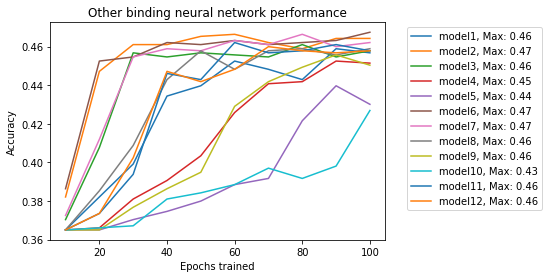

In [88]:
# other binding
# RERUN
x = [10,20,30,40,50, 60, 70, 80, 90, 100]
model1 = [0.3649946638207044, 0.3820704375667022, 0.3991462113127001, 0.4343649946638207, 0.439701173959445, 0.45250800426894344, 0.44823906083244397, 0.4429028815368196, 0.4589114194236926, 0.4567769477054429]
model2 = [0.3820704375667022, 0.4471718249733191, 0.4610458911419424, 0.4610458911419424, 0.46531483457844186, 0.4663820704375667, 0.4621131270010672, 0.4589114194236926, 0.464247598719317, 0.464247598719317]
model3 = [0.3703308431163287, 0.40768409818569906, 0.4567769477054429, 0.45464247598719315, 0.4567769477054429, 0.45570971184631803, 0.45464247598719315, 0.4610458911419424, 0.45464247598719315, 0.4578441835645678]
model4 = [0.3649946638207044, 0.3660618996798292, 0.3810032017075774, 0.39060832443970117, 0.4034151547491996, 0.4258271077908218, 0.4407684098185699, 0.4418356456776948, 0.45250800426894344, 0.45144076840981856]
model5 = [0.3649946638207044, 0.3649946638207044, 0.3703308431163287, 0.37459978655282816, 0.3799359658484525, 0.38847385272145146, 0.39167556029882605, 0.4215581643543223, 0.439701173959445, 0.43009605122732125]
model6 = [0.3863393810032017, 0.45250800426894344, 0.45464247598719315, 0.4621131270010672, 0.4610458911419424, 0.4631803628601921, 0.4610458911419424, 0.4621131270010672, 0.4631803628601921, 0.46744930629669157]
model7 = [0.37246531483457845, 0.4119530416221985, 0.45464247598719315, 0.4589114194236926, 0.4578441835645678, 0.4631803628601921, 0.4610458911419424, 0.4663820704375667, 0.4599786552828175, 0.4621131270010672]
model8 = [0.3649946638207044, 0.3852721451440768, 0.4087513340448239, 0.4429028815368196, 0.4578441835645678, 0.44823906083244397, 0.4578441835645678, 0.4589114194236926, 0.45570971184631803, 0.4589114194236926]
model9 = [0.3649946638207044, 0.3649946638207044, 0.3767342582710779, 0.3863393810032017, 0.39487726787620064, 0.42902881536819637, 0.4418356456776948, 0.44930629669156885, 0.45570971184631803, 0.4503735325506937]
model10 = [0.3649946638207044, 0.3660618996798292, 0.3671291355389541, 0.3810032017075774, 0.384204909284952, 0.38847385272145146, 0.39701173959445035, 0.39167556029882605, 0.39807897545357523, 0.42689434364994666]
model11 =  [0.3649946638207044, 0.37353255069370334, 0.39381003201707576, 0.44610458911419426, 0.4429028815368196, 0.4621131270010672, 0.4567769477054429, 0.4578441835645678, 0.4610458911419424, 0.4578441835645678]
model12 = [0.3649946638207044, 0.37353255069370334, 0.4023479188900747, 0.4471718249733191, 0.4418356456776948, 0.44823906083244397, 0.4599786552828175, 0.4578441835645678, 0.4567769477054429, 0.4578441835645678]

plt.figure(1)
for i, label in zip((model1, model2, model3, model4, model5, model6, model7, model8, model9, model10, model11, model12), ['model1', 'model2', 'model3', 'model4', 'model5', 'model6', 'model7', 'model8', 'model9', 'model10', 'model11', 'model12']):
    test_list = [label, str(round(max(i),2))]
    plt.plot(x, i, label=", Max: ".join(test_list))
plt.title("Other binding neural network performance")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Epochs trained")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# big ol plotter

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [22]:


for i in (1,2,3,4,5):
    model10.fit(train_sequences, train_targets, epochs=10)
    test_loss, test_acc = model10.evaluate(test_sequences,  test_targets, verbose=2)
    print("Model 10, run: ", runcount, ": Acc", test_acc) 
    runcount += 1

Epoch 1/10
96/96 [==============================] - 51s 533ms/step - loss: 0.0017 - accuracy: 0.2611
Epoch 2/10
96/96 [==============================] - 64s 662ms/step - loss: 0.0017 - accuracy: 0.2908
Epoch 3/10
96/96 [==============================] - 67s 696ms/step - loss: 0.0016 - accuracy: 0.2873
Epoch 4/10
96/96 [==============================] - 67s 697ms/step - loss: 0.0016 - accuracy: 0.3212
Epoch 5/10
96/96 [==============================] - 66s 686ms/step - loss: 0.0015 - accuracy: 0.3275
Epoch 6/10
96/96 [==============================] - 66s 689ms/step - loss: 0.0014 - accuracy: 0.3458
Epoch 7/10
96/96 [==============================] - 63s 655ms/step - loss: 0.0014 - accuracy: 0.3634
Epoch 8/10
96/96 [==============================] - 62s 645ms/step - loss: 0.0013 - accuracy: 0.3716
Epoch 9/10
96/96 [==============================] - 61s 641ms/step - loss: 0.0014 - accuracy: 0.3788
Epoch 10/10
96/96 [==============================] - 66s 686ms/step - loss: 0.0013 - accura

In [27]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

cvscores = []
for train, test in kfold.split(X, y):
  # create model
    model_k = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(2986,)),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(2986, activation='softmax')
    ])
    # Compile model
    model_k.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    model_k.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    scores = model.evaluate(X[test], Y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'multilabel-indicator' instead.

In [22]:
# load info file
df_act = pd.read_csv("protein_act_site.tsv", sep="\t")
df_binding = pd.read_csv("protein_binding.tsv", sep="\t")
df_metal = pd.read_csv("protein_metal.tsv", sep="\t")
df_dna_bind = pd.read_csv("protein_dna_bind.tsv", sep="\t")



sequence_list = df_act['Sequence'].tolist()
active_list = df_act['Active site'].tolist()


def shorten(df, length):
    sequence_list = df['Sequence'].tolist()
    df['length'] = [len(i) for i in sequence_list]
    df_shorter = df[df['length'] < length]
    return df_shorter


def get_lists(df, colname):
    seq_list = df['Sequence'].tolist()
    act_list = df[colname].tolist()
    return seq_list, act_list


df_act['length'] = [len(i) for i in sequence_list]
df_short = df_act[df_act['length'] < 3000]
#print(df_short)
short_sequence_list = df_short['Sequence'].tolist()
short_active_list = df_short['Active site'].tolist()
length_values = max([len(i) for i in short_sequence_list])
# data prep



acid_code_dict = {"A":"1", "B":"2", "C":"3", "D":"4", "E":"5", "F":"6", "G":"7", "H":"8",
                  "I":"9", "J":"10", "K":"11", "L":"12", "M":"13", "N":"14", "O":"15", "P":"16",
                  "Q":"17", "R":"18", "S":"19", "T":"20", "U":"21", "V":"22", "W":"23", "X":"24",
                  "Y":"25", "Z":"26"}

# prob just turn it into an array as a whole and not a list of arrays but what do i know. 
# one hot encoding of the different amino acids
def one_of_each(seq_list, size):
    #length_values = size
    new_seq_list = []
    for seq in seq_list:
        new_acid_list = np.zeros(size)
        for acid in enumerate(seq):
            new_acid_list[acid[0]] = (int(acid_code_dict[acid[1]]) / 25) # normalize the data?
        new_seq_list.append(new_acid_list)
    return np.asarray(new_seq_list)


#X = one_of_each(short_sequence_list, length_values)
#print(one_of_each(sequence_list, length_values)[0])

def target_regions(target_list, size, regionname):
    new_list = []
    counter = 0
    for target in target_list:
        empty_array = np.zeros(size)
        #print(target)
        if regionname == "DNA_BIND":
            if isinstance(target, str):
                list_of_targets = re.findall('{} [0-9]+\.\.[0-9]+'.format(regionname), target)
            for position in list_of_targets:
                #print(position)
                start = position.split(" ")[1].split("..")[0]
                end = position.split(" ")[1].split("..")[1]
            #print(pos_number)
                #print(start, end)
                for number in range(int(start), int(end)):
                    counter += 1
                    empty_array[int(number)] = 1
        else:
            if isinstance(target, str):
                #print(target)
                list_of_targets = re.findall('{} [0-9]+'.format(regionname), target)
            #print(list_of_targets)
        #print(list_of_targets)
            for position in list_of_targets:
                pos_number = position.split(" ")[1]
            #print(pos_number)
                counter +=1
                empty_array[int(pos_number)] = 1
        new_list.append(empty_array)
    print(regionname, counter)
    return np.asarray(new_list)

#y = target_regions(short_active_list, length_values)
#print(target_regions(active_list, length_values))
#print(len(max(sequence_list)))
# create vectors of the size of the biggest sequence encode the amino acids 1-idk 20 ish 

# annotate the active regions with a 1 and leave the rest zero

#print(max([len(i) for i in sequence_list]))


# either 1 region per sequence or multiple at the same time. 
size = 3000
X_act_list, y_act_list = get_lists(shorten(df_act, size), 'Active site')
X_binding_list, y_binding_list = get_lists(shorten(df_binding, size), 'Binding site')
X_metal_list, y_metal_list = get_lists(shorten(df_metal, size), 'Metal binding')
X_dna_bind_list, y_dna_bind_list = get_lists(shorten(df_dna_bind, size), 'DNA binding')

#print(y_binding_list)
X_act = one_of_each(X_act_list, size)
X_binding = one_of_each(X_binding_list, size)
X_metal = one_of_each(X_metal_list, size)
X_dna_bind = one_of_each(X_dna_bind_list, size)

y_act = target_regions(y_act_list, size, "ACT_SITE")
y_binding = target_regions(y_binding_list, size, "BINDING")
y_metal = target_regions(y_metal_list, size, "METAL")
y_dna_bind = target_regions(y_dna_bind_list, size, "DNA_BIND")


#print(X.shape)
#print(y.shape)
print(X_act.shape, X_binding.shape, X_metal.shape, X_dna_bind.shape)
print(y_act.shape, y_binding.shape, y_metal.shape, y_dna_bind.shape)

ACT_SITE 6007
BINDING 10368
METAL 18330
DNA_BIND 111337
(3825, 3000) (4682, 3000) (4055, 3000) (1582, 3000)
(3825, 3000) (4682, 3000) (4055, 3000) (1582, 3000)


In [23]:
X = X_dna_bind
y = y_dna_bind
train_sequences, test_sequences, train_targets, test_targets = train_test_split(X, y, test_size=0.2)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3000,)),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='sigmoid')
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

for i in (1,2,3,4,5):
    model.fit(train_sequences, train_targets, epochs=10)
    test_loss, test_acc = model.evaluate(test_sequences,  test_targets, verbose=2)
    print(i)

Epoch 1/10
40/40 [==============================] - 3s 74ms/step - loss: 0.2122 - accuracy: 0.0075
Epoch 2/10
40/40 [==============================] - 3s 74ms/step - loss: 0.0573 - accuracy: 0.0067
Epoch 3/10
40/40 [==============================] - 3s 78ms/step - loss: 0.0511 - accuracy: 0.0110
Epoch 4/10
40/40 [==============================] - 3s 81ms/step - loss: 0.0472 - accuracy: 0.0130
Epoch 5/10
40/40 [==============================] - 3s 85ms/step - loss: 0.0448 - accuracy: 0.0378
Epoch 6/10
40/40 [==============================] - 4s 92ms/step - loss: 0.0390 - accuracy: 0.0109
Epoch 7/10
40/40 [==============================] - 4s 88ms/step - loss: 0.0365 - accuracy: 0.0139
Epoch 8/10
40/40 [==============================] - 4s 90ms/step - loss: 0.0333 - accuracy: 0.0234
Epoch 9/10
40/40 [==============================] - 4s 93ms/step - loss: 0.0293 - accuracy: 0.0172
Epoch 10/10
40/40 [==============================] - 4s 96ms/step - loss: 0.0260 - accuracy: 0.0149
10/10 - 0

KeyboardInterrupt: 

In [5]:
# create final models

# mlp for multi-label classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import RepeatedKFold
#from keras.models import Sequential
#from keras.layers import Dense
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# get the dataset
def get_dataset():
    X, y = make_multilabel_classification(n_samples=1000, n_features=10, n_classes=3, n_labels=2, random_state=1)
    return X, y

# get the model
def get_model():
    model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3000,)),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
    # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = get_model()
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs=50)
        # make a prediction on the test set
        yhat = model.predict(X_test)
        # round probabilities to class labels
        yhat = yhat.round()
        # calculate accuracy
        acc = accuracy_score(y_test, yhat)
        #roc = roc_auc_score(y_test, yhat)
        #print(roc)
        # store result
        print('>%.3f' % acc)
        results.append(acc)
    return results

# load dataset
X = X_act
y = y_act
# evaluate model
act_results = evaluate_model(X, y)
# summarize performance
print('Accuracy: %.3f (%.3f)' % (mean(act_results), std(act_results)))


>0.294
>0.276
>0.297
>0.297
>0.314
Accuracy: 0.295 (0.012)


In [26]:
# get the model
def get_model():
    model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3000,)),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
    # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = get_model()
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs=80)
        # make a prediction on the test set
        yhat = model.predict(X_test)
        # round probabilities to class labels
        yhat = yhat.round()
        # calculate accuracy
        acc = accuracy_score(y_test, yhat)
        # store result
        print('>%.3f' % acc)
        results.append(acc)
    return results

# load dataset
X = X_dna_bind
y = y_dna_bind
# evaluate model
act_results = evaluate_model(X, y)
# summarize performance
print('Accuracy: %.3f (%.3f)' % (mean(act_results), std(act_results)))

>0.319


KeyboardInterrupt: 

In [45]:
# get the model
def get_model():
    model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3000,)),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
    # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = get_model()
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs=50)
        # make a prediction on the test set
        yhat = model.predict(X_test)
        # round probabilities to class labels
        yhat = yhat.round()
        # calculate accuracy
        acc = accuracy_score(y_test, yhat)
        # store result
        print('>%.3f' % acc)
        results.append(acc)
    return results

# load dataset
X = X_binding
y = y_binding
# evaluate model
act_results = evaluate_model(X, y)
# summarize performance
print('Accuracy: %.3f (%.3f)' % (mean(act_results), std(act_results)))

>0.489
>0.467
>0.466
>0.519
>0.458
Accuracy: 0.480 (0.022)


In [42]:
# get the model
def get_model():
    model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3000,)),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(3000, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
    # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = get_model()
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs=50)
        # make a prediction on the test set
        yhat = model.predict(X_test)
        # round probabilities to class labels
        yhat = yhat.round()
        # calculate accuracy
        acc = accuracy_score(y_test, yhat)
        # store result
        print('>%.3f' % acc)
        results.append(acc)
    return results

# load dataset
X = X_metal
y = y_metal
# evaluate model
act_results = evaluate_model(X, y)
# summarize performance
print('Accuracy: %.3f (%.3f)' % (mean(act_results), std(act_results)))

>0.503
>0.556
>0.517
>0.573
>0.544
Accuracy: 0.539 (0.026)


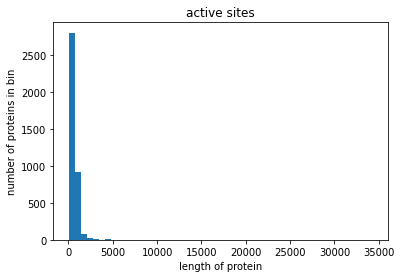

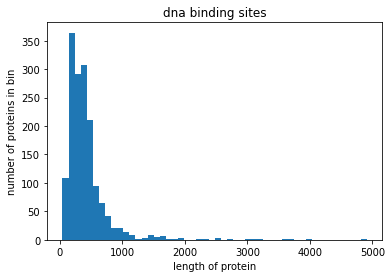

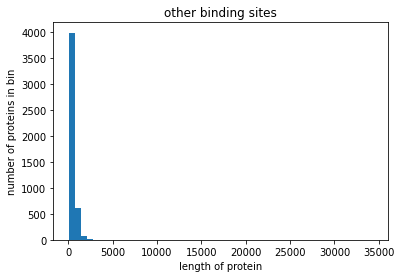

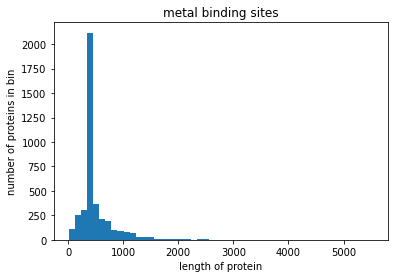

In [15]:
import matplotlib.pyplot as plt

df_act = pd.read_csv("protein_act_site.tsv", sep="\t")
df_binding = pd.read_csv("protein_binding.tsv", sep="\t")
df_metal = pd.read_csv("protein_metal.tsv", sep="\t")
df_dna_bind = pd.read_csv("protein_dna_bind.tsv", sep="\t")

def plot_hist(df, title):
    sequence_list = df['Sequence'].tolist()
    length_list = [len(i) for i in sequence_list]
    #length_list = [len(i) for i in sequence_list if len(i) < 5000]
    #df_shorter = df[df['length'] < 5000]
    plt.hist(length_list, bins = 50)
    plt.xlabel('length of protein')
    plt.ylabel('number of proteins in bin')
    plt.title(title)
    plt.show()
    #return df_shorter

sequence_list = df_dna_bind['Sequence'].tolist()
#length_list = [len(i) for i in sequence_list]
length_list = [len(i) for i in sequence_list]
#print(mean(length_list))    
plot_hist(df_act, 'active sites')
plot_hist(df_dna_bind, 'dna binding sites')
plot_hist(df_binding, 'other binding sites')
plot_hist(df_metal, 'metal binding sites')



